# To Do List

In [ ]:
"""
* Birimler hard copy olmasın girdiğin veriden çekilsin
* colorbarlar, levellar
* adveksiyon hesabı
* vertical velocity hesabı
* xwrf
"""

# Imports

In [1]:
from wrf import getvar, ALL_TIMES, smooth2d, extract_times, latlon_coords, get_cartopy, interplevel, to_np, vinterp, ll_to_xy
from wrf.g_geoht import get_height
from metpy.units import units
import metpy.calc as calc
import metpy as mp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import xarray as xr
from netCDF4 import Dataset
import os
from matplotlib.colors import ListedColormap
from ituamt import AMTPlotter

# Data

In [2]:
wrfout = Dataset(r"C:\Users\gkbrk\Desktop\modelleme\github\modelleme\hadise1\set_a1\set_a1_d01")
fig_path = "C://Users//gkbrk//Desktop//"

In [4]:
wrfout=Dataset(r"/Users/gkbrkgrr/hadise1/set_a1/set_a1_d01")

# Classes & Functions

## Basic Plot Class

In [9]:
class MapPlotter:
    def __init__(self, lons, lats, cproj, title='Map Plot', cmap='viridis'):
        """
        Initializes the MapPlotter object with necessary attributes.
        :param input_data: 2D array of data points to plot.
        :param title: Title of the plot.
        :param cmap: Colormap for the filled contour plot.
        :param contourf_levels: Optional levels for the filled contour plot.
        """
        self.lons = lons
        self.lats = lats
        self.title = title
        self.cmap = cmap
        self.cproj = cproj
        
        self.fig = plt.figure(figsize=(12.80, 7.2), layout="compressed", dpi=96.)
        self.ax = plt.axes(projection=self.cproj)
        self.ax.set_title(self.title, loc="left")
        self.ax.coastlines()

    def add_contourf(self, data, levels=None, extend="both"):
        """
        Plots the filled contour plot using the specified attributes.
        If contourf_levels is None, the levels parameter is omitted.
        Stores the contourf plot object for later use, e.g., by add_colorbar.
        """
        if levels is not None:
            self.contourf_plot = self.ax.contourf(self.lons, self.lats, data, levels=levels, cmap=self.cmap, extend=extend, transform=ccrs.PlateCarree())
        else:
            self.contourf_plot = self.ax.contourf(self.lons, self.lats, data, cmap=self.cmap, extend=extend, transform=ccrs.PlateCarree())    

    def add_contour(self, data, levels=None):
        """
        Adds contour lines to the plot.
        :param line_levels: Optional levels for the contour lines.
        :param colors: Color of the contour lines.
        """

        if levels is not None:
            contour_lines = self.ax.contour(self.lons, self.lats, data, levels=levels, colors='black', linewidths=1, transform=ccrs.PlateCarree())
        else:
            contour_lines = self.ax.contour(self.lons, self.lats, data, colors='black', linewidths=1, transform=ccrs.PlateCarree())
        self.ax.clabel(contour_lines, inline=1, fontsize=10, fmt="%i")
    
    def add_wind_barbs(self, u, v, gap):
        """
        Adds wind barbs to the plot.  
        """
        plt.barbs(to_np(self.lons[::gap, ::gap]), to_np(self.lats[::gap, ::gap]), to_np(u[::gap, ::gap]), to_np(v[::gap, ::gap]), transform=ccrs.PlateCarree(), length=6)
    
    def add_timestamp(self, time):
        time = time + timedelta(hours=3)
        dtime = time.strftime("%d-%m-%Y %H:%M") 
        self.ax.set_title(f"{dtime} +03 UTC", loc="right")

    def add_colorbar(self, ticks=None):
        """
        Adds a colorbar to the plot using the stored contourf plot object.
        """
        if self.contourf_plot is not None:
            self.fig.colorbar(self.contourf_plot, ax=self.ax, extend="both", aspect=50, orientation="horizontal")
        else:
            raise ValueError("No contourf plot available. Please call add_contourf before adding a colorbar.")
    
    def show_plot(self):
        """
        Displays the plot.
        """
        plt.show()
    def close_plot(self):
        """
        Closes the plot.
        """
        plt.close()

    def save_plot(self, path, name):
        """
        Saves the plot.     
        """
        self.fig.savefig(f"{path}{name}.png", format="png", dpi=150)

## Ground Functions

### 2 Meter Temperature Function

In [141]:
def plot_t2(data, timestep):
    plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title="2 Metre Sıcaklık (°C)", cmap="jet")
    plotter.add_contourf(data[timestep])
    plotter.add_colorbar()
    plotter.add_timestamp(times[timestep])

### 2 Meter Dewpoint Function

In [140]:
def plot_td2(data, timestep):
    plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title="2 Metre Çiğ Noktası Sıcaklığı (°C)", cmap="jet")
    plotter.add_contourf(data[timestep])
    plotter.add_colorbar()
    plotter.add_timestamp(times[timestep])

## Height Over Temperature Function

In [7]:
def plot_height_over_temp(height_data, temp_data, timestep, level):
    selector = levels.get(level, None)

    plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title=f"{level} hPa Sıcaklık (°C), Jeopotansiyel Yükseklik (dam)", cmap="jet")
    plotter.add_contourf(temp_data[timestep, selector], levels=levels_dict[str(level)]["temp"])
    plotter.add_contour(height_data[timestep, selector], levels=levels_dict[str(level)]["height"])
    plotter.add_colorbar()
    plotter.add_timestamp(times[timestep])

## Slp Over Eth Function

In [88]:
def plot_slp_over_eth(slp_data, eth_data, timestep, level):
    selector = levels.get(level, None)

    plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title=f"{level} hPa Eşdeğer Potansiyel Sıcaklık (°C), Deniz Seviyesi Basıncı (hPa)")
    plotter.add_contour(slp_data[timestep])
    plotter.add_contourf(eth_data[timestep, selector])
    plotter.add_colorbar()
    plotter.add_timestamp(times[timestep])

## Height Over Temperature Advection Function

In [21]:
def plot_height_over_tempadv(height_data, tempadv_data, timestep, level):
    selector = levels.get(level, None)

    plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title=f"{level} hPa Sıcaklık Taşınımı (K/saat), Jeopotansiyel Yükseklik (dam)", cmap="jet")
    plotter.add_contourf(tempadv_data[timestep, selector], levels=levels_dict[str(level)]["temp"])
    plotter.add_contour(height_data[timestep, selector], levels=levels_dict[str(level)]["height"]) 
    plotter.add_colorbar()
    plotter.add_timestamp(times[timestep])

## Wind Barbs Over Wind Speed Function

In [22]:
def plot_jet(u, v, ws, timestep, gap, level):
    if level == 10:
        plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title=f"10 Metre Rüzgar (m/s)")
        plotter.add_contourf(ws[timestep])
        plotter.add_wind_barbs(u=u[timestep], v=v[timestep], gap=gap)
        plotter.add_colorbar()
        plotter.add_timestamp(times[timestep])
    else: 
        selector = levels.get(level, None)
        plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title=f"{level} hPa Rüzgar (m/s)")
        plotter.add_contourf(ws[timestep, selector])
        plotter.add_wind_barbs(u=u[timestep, selector], v=v[timestep, selector], gap=gap)
        plotter.add_colorbar()
        plotter.add_timestamp(times[timestep])

## RH Function

In [60]:
def plot_rh700(data, timestep):
    plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, title="700 hPa Bağıl Nem (%)", cmap=levels_dict["700"]["cmap"])
    plotter.add_contour(data[timestep], levels=[15, 30, 45, 60, 75, 90])
    plotter.add_contourf(data[timestep], levels=[60, 75, 90, 100], extend="max")
    plotter.add_colorbar()
    plotter.add_timestamp(times[timestep])

## Vorticity Functions

### 500 hPa Rel. Vorticity

In [49]:
def plot_relvo500(data, u, v, timestep, gap):
    plotter = MapPlotter(lons, lats, cproj, title="500 hPa Bağıl Burgaçlanma ($10^{-5}$/s)")
    plotter.add_contourf(data[timestep])
    plotter.add_wind_barbs(u=u[timestep][3], v=v[timestep][3], gap=gap)
    plotter.add_colorbar()
    plotter.add_timestamp(time=times[timestep])

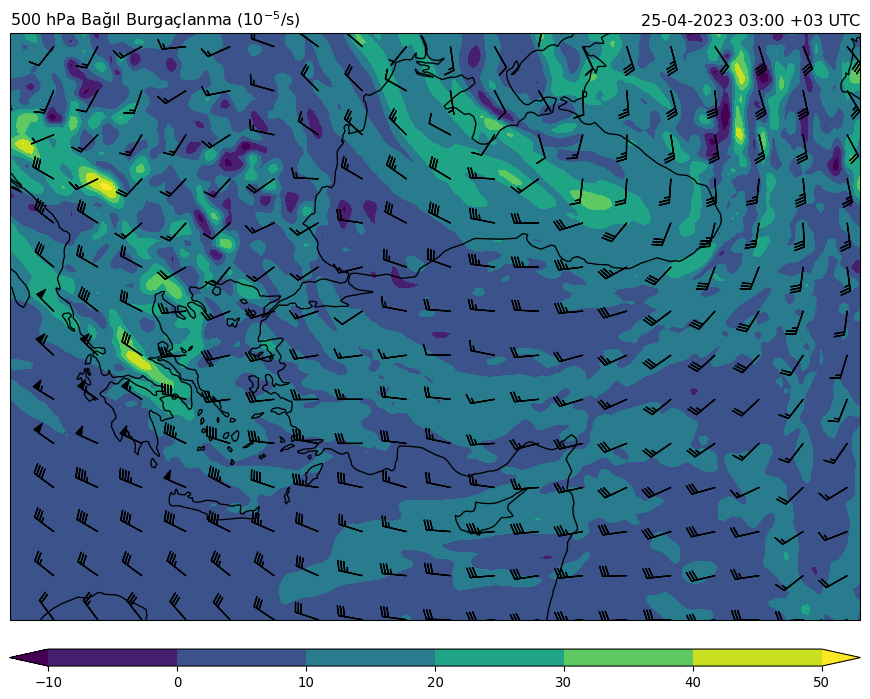

In [52]:
plot_relvo500(rvo_500, u_levels, v_levels, 0, 10)

# Hesaplar

In [3]:
levels_dict = { "1000": {"height": np.arange(0, 204, 8), "temp": np.arange(-36, 34, 2), "windkt": None},
                "850": {"height": np.arange(100, 204, 4), "temp": np.arange(-36, 34, 2), "windkt": None},
                "700": {"height": np.arange(250, 350, 3), "temp": np.arange(-36, 34, 2), "windkt": None, "cmap": ListedColormap(["paleturquoise","lightskyblue","deepskyblue"])},
                "500": {"height": np.arange(500, 606, 3), "temp": np.arange(-36, 34, 2), "windkt": None},
                "300": {"height": np.arange(800, 1120, 8), "temp": np.arange(-36, 34, 2), "windkt": None},
                "200": {"height": np.arange(900, 1308, 8), "temp": np.arange(-36, 34, 2), "windkt": None}}

In [8]:
dx = wrfout.DX * units.m
dy = wrfout.DY * units.m
levels = {1000: 0, 850: 1, 700: 2, 500: 3, 300: 4, 200: 5}
times = pd.to_datetime(extract_times(wrfout, ALL_TIMES))
temp = getvar(wrfout, 'tk', timeidx=ALL_TIMES)
tempc = getvar(wrfout, 'tc', timeidx=ALL_TIMES)
lats, lons = latlon_coords(temp)
cproj = get_cartopy(temp)

pressure = getvar(wrfout, 'pressure', timeidx=ALL_TIMES)
height = getvar(wrfout, 'z', units='dam', timeidx=ALL_TIMES)
rh = getvar(wrfout, "rh", timeidx=ALL_TIMES)
ua = getvar(wrfout, "ua", units="kt", timeidx=ALL_TIMES)
va = getvar(wrfout, "va", units="kt", timeidx=ALL_TIMES)
wa = getvar(wrfout, "wa", units="kt", timeidx=ALL_TIMES)
wspd = getvar(wrfout, "wspd_wdir", units="m/s", timeidx=ALL_TIMES)[0]
t2 = getvar(wrfout, "T2", timeidx=ALL_TIMES).metpy.convert_units("degC")
td2 = getvar(wrfout, "td2", units="degC", timeidx=ALL_TIMES)
eth = getvar(wrfout, "eth", units="degC", timeidx=ALL_TIMES)
omega = getvar(wrfout, "omega", timeidx=ALL_TIMES).metpy.convert_units("hPa/h")
slp = getvar(wrfout, "slp", units="hPa", timeidx=ALL_TIMES)

u10 = getvar(wrfout, "uvmet10", units="kt", timeidx=ALL_TIMES)[0]
v10 = getvar(wrfout, "uvmet10", units="kt", timeidx=ALL_TIMES)[1]
wspd10 = getvar(wrfout, "wspd_wdir10", units="m/s", timeidx=ALL_TIMES)[0]

temp_levels = vinterp(wrfout, field=temp, vert_coord='pressure', interp_levels=list(levels.keys()), extrapolate=True, field_type='tk', log_p=True, timeidx=ALL_TIMES)
tempc_levels = vinterp(wrfout, field=tempc, vert_coord='pressure', interp_levels=list(levels.keys()), extrapolate=True, field_type='tc', log_p=True, timeidx=ALL_TIMES)
rh_700 = interplevel(rh, pressure, 700)
u_levels = interplevel(ua, pressure, list(levels.keys()))
v_levels = interplevel(va, pressure, list(levels.keys()))
w_levels = interplevel(wa, pressure, list(levels.keys()))
ws_levels = interplevel(wspd, pressure, list(levels.keys()))
height_levels = smooth2d(vinterp(wrfout, field=height, vert_coord='pressure', interp_levels=list(levels.keys()), extrapolate=True, field_type='z', log_p=True, timeidx=ALL_TIMES).metpy.convert_units("dam"), 355)
eth_levels = smooth2d(vinterp(wrfout, field=eth, vert_coord="pressure", interp_levels=list(levels.keys()), extrapolate=True, field_type='eth', log_p=True, timeidx=ALL_TIMES), 10)



In [18]:
tempc_adv = calc.advection(tempc, ua.metpy.convert_units("m/s"), va.metpy.convert_units("m/s"), dx=dx, dy=dy).metpy.convert_units("K/h")
tempc_adv = vinterp(wrfout, field=tempc_adv, vert_coord='pressure', interp_levels=list(levels.keys()), extrapolate=True, field_type='tc', log_p=True, timeidx=ALL_TIMES)

C:\Users\gkbrk\AppData\Local\Temp\ipykernel_8212\2757061642.py:1: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  tempc_adv = calc.advection(tempc, ua.metpy.convert_units("m/s"), va.metpy.convert_units("m/s"), dx=dx, dy=dy).metpy.convert_units("K/h")


In [72]:
avo = (getvar(wrfout, "avo", timeidx=ALL_TIMES).values * 10**-5) * units("1/second")

In [9]:
f = (2 * 7 * 10**-5 * np.sin(np.deg2rad(lats))).values * units("1/second") 

In [10]:
rvo = (avo_levels - f) * 10**5

In [13]:
rvo[0,1,0,0]

2.5732362701091915 <Unit('1 / second')>

In [109]:
avo_adv_levels = (calc.advection(avo_levels, u_levels.metpy.convert_units("m/s"), v_levels.metpy.convert_units("m/s"), dx=dx, dy=dy).magnitude * 3600**2) * units("1/hour**2")

C:\Users\gkbrk\AppData\Local\Temp\ipykernel_8212\4185770152.py:1: UserWarning: Horizontal dimension numbers not found. Defaulting to (..., Y, X) order.
  avo_adv = (calc.advection(avo_levels, u_levels.metpy.convert_units("m/s"), v_levels.metpy.convert_units("m/s"), dx=dx, dy=dy).magnitude * 3600**2) * units("1/hour**2")
C:\Users\gkbrk\AppData\Local\Temp\ipykernel_8212\4185770152.py:1: UserWarning: Vertical dimension number not found. Defaulting to (..., Z, Y, X) order.
  avo_adv = (calc.advection(avo_levels, u_levels.metpy.convert_units("m/s"), v_levels.metpy.convert_units("m/s"), dx=dx, dy=dy).magnitude * 3600**2) * units("1/hour**2")


In [5]:
avo_levels = (vinterp(wrfout, getvar(wrfout, "avo", timeidx=ALL_TIMES), vert_coord="pressure", interp_levels=list(levels.keys()), timeidx=ALL_TIMES).values * 10**-5) * units("1/second")

In [127]:
plotter1 = AMTPlotter()

<Figure size 1228.8x691.2 with 0 Axes>

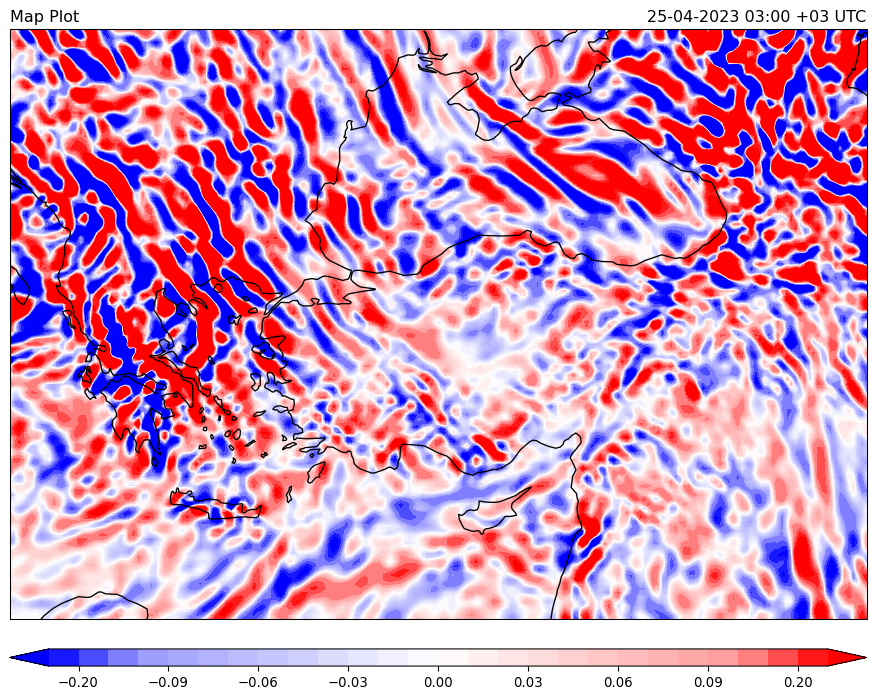

In [147]:
plotter = MapPlotter(lons=lons, lats=lats, cproj=cproj, cmap="bwr")
plotter.add_contourf(avo_adv[0, 3], levels=np.concatenate([np.arange(-0.25, -0.09, 0.05), np.arange(-0.09, 0.1, 0.01), np.arange(0.1, 0.26, 0.05)]))
plotter.add_colorbar()
plotter.add_timestamp(times[0])

In [144]:
np.arange(-0.09, 0.1, 0.01)

array([-9.00000000e-02, -8.00000000e-02, -7.00000000e-02, -6.00000000e-02,
       -5.00000000e-02, -4.00000000e-02, -3.00000000e-02, -2.00000000e-02,
       -1.00000000e-02, -4.16333634e-17,  1.00000000e-02,  2.00000000e-02,
        3.00000000e-02,  4.00000000e-02,  5.00000000e-02,  6.00000000e-02,
        7.00000000e-02,  8.00000000e-02,  9.00000000e-02])

In [143]:
np.concatenate([np.arange(-0.25, -0.09, 0.05), np.arange(-0.09, 0.1, 0.01), np.arange(0.1, 0.26, 0.05)])

array([-2.50000000e-01, -2.00000000e-01, -1.50000000e-01, -1.00000000e-01,
       -9.00000000e-02, -8.00000000e-02, -7.00000000e-02, -6.00000000e-02,
       -5.00000000e-02, -4.00000000e-02, -3.00000000e-02, -2.00000000e-02,
       -1.00000000e-02, -4.16333634e-17,  1.00000000e-02,  2.00000000e-02,
        3.00000000e-02,  4.00000000e-02,  5.00000000e-02,  6.00000000e-02,
        7.00000000e-02,  8.00000000e-02,  9.00000000e-02,  1.00000000e-01,
        1.50000000e-01,  2.00000000e-01,  2.50000000e-01])